In [ ]:
import matplotlib.pyplot as plt

In [35]:

def plot_trajectory(filename : str, title : str):
    
    trajectory = []

    with open("data/" + filename + ".a") as file:
        for l, line, in enumerate(file):
            if l >= 10:
                trajectory.append(line.split()[1:4])
    
    fig=plt.figure(figsize=(8, 8))
    ax=fig.add_subplot(projection='3d')
    
    ax.plot(
        [ float(x[0]) for x in trajectory],
        [ float(x[2]) for x in trajectory],
        [-float(x[1]) for x in trajectory])
    
    plt.xlabel("xaxis")
    plt.ylabel("yaxis")
    plt.title(title)
    ax.set_zlabel("zaxis")
    ax.set_zbound(lower=0, upper=110)
    ax.set_xbound(lower=-60, upper=60)
    ax.set_ybound(lower=-60, upper=60)
    plt.show()


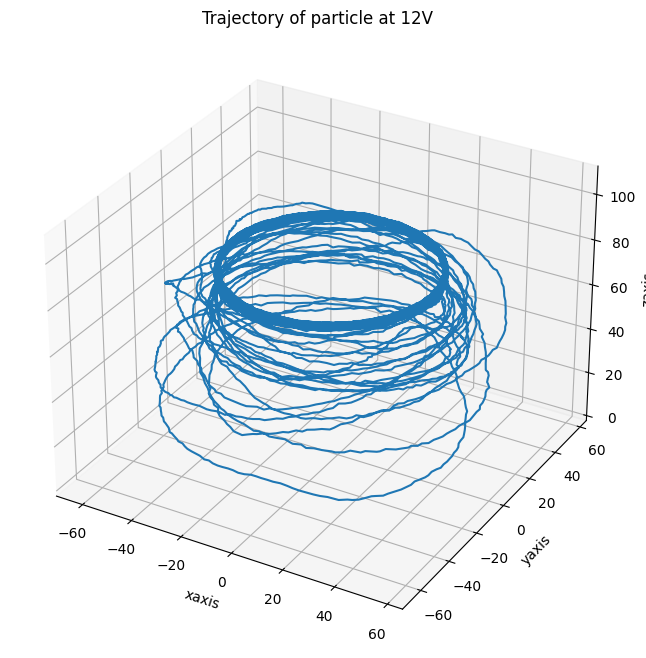

In [27]:
plot_trajectory("m0_12V", "Trajectory of particle at 12V")


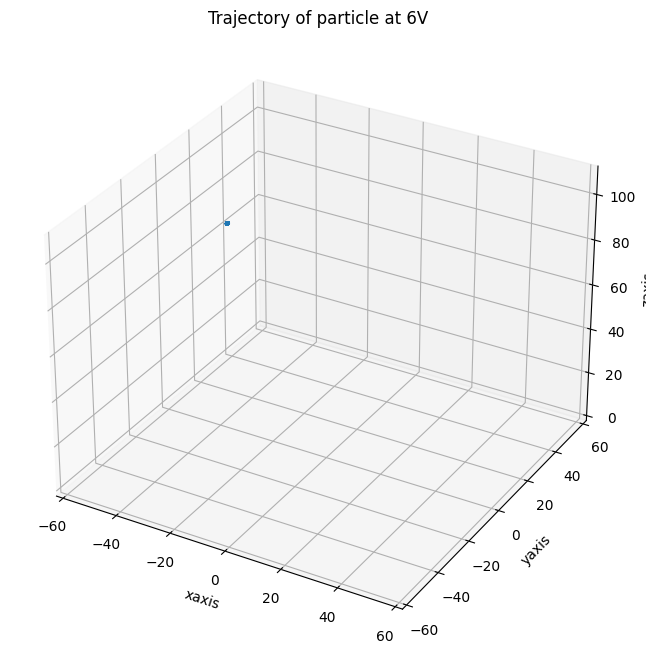

In [36]:
plot_trajectory("m0_6V", "Trajectory of particle at 6V")

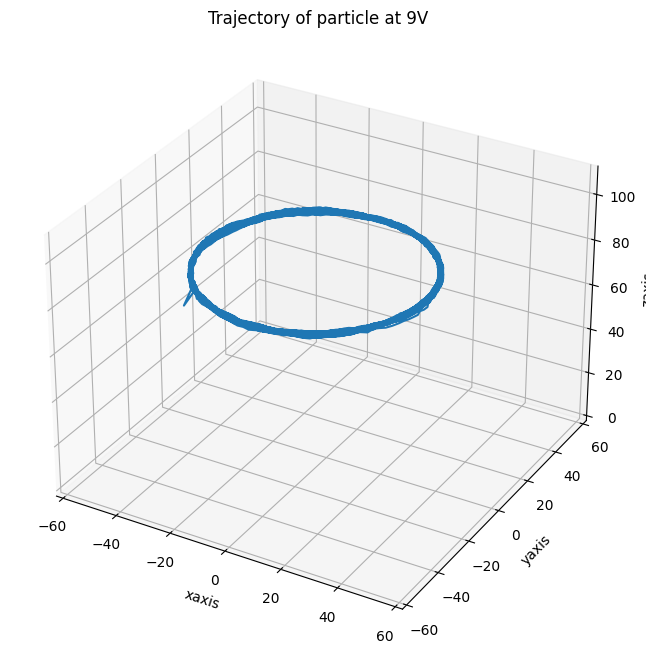

In [37]:
plot_trajectory("m0_9V", "Trajectory of particle at 9V")